<a href="https://colab.research.google.com/github/datadigger01/AI-Trade/blob/main/ML_model_multistep_fc_ex21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests

url = "https://raw.githubusercontent.com/datadigger01/AI-Trade/main/Data/coffee_future_price.csv"
response = requests.get(url)

# Save the content to a temporary file
with open("price_data.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file into a pandas DataFrame, skipping the first two rows
df = pd.read_csv("price_data.csv")

# Display the first few rows of the DataFrame
display(df.head())

,Date,Close_Price,High_Price,Low,Open,Volume
0,2020-11-05,105.949997,106.800003,103.550003,103.900002,29467
1,2020-11-06,106.949997,108.000000,105.949997,106.550003,18754
2,2020-11-09,106.849998,109.349998,106.349998,107.349998,26289
3,2020-11-10,107.300003,107.650002,105.349998,106.750000,28673
4,2020-11-11,109.099998,110.550003,107.800003,108.000000,25497


### Feature 생성

In [2]:
"""
커피 가격 예측을 위한 Feature Engineering 함수 모듈

사용 예시:
    from coffee_features import create_all_features

    df = pd.read_csv('price_data.csv')
    df_with_features = create_all_features(df)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def create_lag_features(df, price_cols=['Close_Price', 'Open', 'High_Price', 'Low'],
                       close_lags=[1, 2, 3, 5, 7, 14, 21, 30],
                       other_lags=[1, 2, 3, 5]):
    """
    과거 가격 정보 Lag Features 생성

    Args:
        df: 원본 데이터프레임
        price_cols: lag를 생성할 컬럼들
        close_lags: Close Price에 대한 lag 기간
        other_lags: 다른 가격들에 대한 lag 기간

    Returns:
        lag feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Close Price Lags
    for lag in close_lags:
        df[f'close_lag_{lag}'] = df['Close_Price'].shift(lag)

    # Open, High, Low Lags
    for lag in other_lags:
        df[f'open_lag_{lag}'] = df['Open'].shift(lag)
        df[f'high_lag_{lag}'] = df['High_Price'].shift(lag)
        df[f'low_lag_{lag}'] = df['Low'].shift(lag)

    return df


def create_return_features(df, periods=[2, 3, 5, 7, 14]):
    """
    가격 변화율 및 수익률 Features 생성

    Args:
        df: 원본 데이터프레임
        periods: 수익률 계산 기간

    Returns:
        return feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Daily Returns
    df['daily_return'] = df['Close_Price'].pct_change(1)
    df['daily_return_lag1'] = df['daily_return'].shift(1)

    # Multi-period Returns
    for period in periods:
        df[f'return_{period}d'] = df['Close_Price'].pct_change(period).shift(1)

    # Price Changes
    df['price_change_1d'] = (df['Close_Price'] - df['Close_Price'].shift(1)).shift(1)
    df['price_change_5d'] = (df['Close_Price'] - df['Close_Price'].shift(5)).shift(1)

    return df


def create_moving_average_features(df, sma_windows=[5, 10, 20, 50, 100],
                                   ema_windows=[5, 10, 20]):
    """
    이동평균 Features 생성

    Args:
        df: 원본 데이터프레임
        sma_windows: 단순이동평균 윈도우 크기
        ema_windows: 지수이동평균 윈도우 크기

    Returns:
        이동평균 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Simple Moving Averages
    for window in sma_windows:
        df[f'sma_{window}'] = df['Close_Price'].rolling(window=window).mean().shift(1)

    # Exponential Moving Averages
    for window in ema_windows:
        df[f'ema_{window}'] = df['Close_Price'].ewm(span=window, adjust=False).mean().shift(1)

    # MA Crossover Features
    df['sma_5_10_diff'] = (df['sma_5'] - df['sma_10'])
    df['sma_10_20_diff'] = (df['sma_10'] - df['sma_20'])
    df['sma_20_50_diff'] = (df['sma_20'] - df['sma_50'])

    # Price relative to MAs
    df['price_to_sma_5'] = (df['Close_Price'] / df['sma_5'].shift(-1)) - 1
    df['price_to_sma_20'] = (df['Close_Price'] / df['sma_20'].shift(-1)) - 1
    df['price_to_sma_50'] = (df['Close_Price'] / df['sma_50'].shift(-1)) - 1

    return df


def create_volatility_features(df, windows=[5, 10, 20], atr_period=14):
    """
    변동성 Features 생성

    Args:
        df: 원본 데이터프레임
        windows: 변동성 계산 윈도우
        atr_period: ATR 계산 기간

    Returns:
        변동성 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Standard Deviation
    daily_return = df['Close_Price'].pct_change(1)
    for window in windows:
        df[f'volatility_{window}d'] = daily_return.rolling(window=window).std().shift(1)

    # High-Low Range
    df['hl_range'] = ((df['High_Price'] - df['Low']) / df['Low']).shift(1)
    df['hl_range_5d_avg'] = df['hl_range'].shift(-1).rolling(window=5).mean().shift(1)

    # ATR (Average True Range)
    df['tr'] = df[['High_Price', 'Close_Price']].max(axis=1) - df[['Low', 'Close_Price']].min(axis=1)
    df['atr_14'] = df['tr'].rolling(window=atr_period).mean().shift(1)

    return df


def create_momentum_features(df, rsi_periods=[7, 14]):
    """
    모멘텀 지표 Features 생성 (RSI, MACD)

    Args:
        df: 원본 데이터프레임
        rsi_periods: RSI 계산 기간

    Returns:
        모멘텀 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # RSI (Relative Strength Index)
    def calculate_rsi(data, period=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    for period in rsi_periods:
        df[f'rsi_{period}'] = calculate_rsi(df['Close_Price'], period).shift(1)

    # MACD
    ema_12 = df['Close_Price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close_Price'].ewm(span=26, adjust=False).mean()
    df['macd'] = (ema_12 - ema_26).shift(1)
    df['macd_signal'] = df['macd'].shift(-1).ewm(span=9, adjust=False).mean().shift(1)
    df['macd_histogram'] = (df['macd'] - df['macd_signal'])

    # Momentum
    df['momentum_5'] = (df['Close_Price'] / df['Close_Price'].shift(5) - 1).shift(1)
    df['momentum_10'] = (df['Close_Price'] / df['Close_Price'].shift(10) - 1).shift(1)

    return df


def create_bollinger_bands(df, window=20, num_std=2):
    """
    볼린저 밴드 Features 생성

    Args:
        df: 원본 데이터프레임
        window: 이동평균 윈도우
        num_std: 표준편차 배수

    Returns:
        볼린저 밴드 feature가 추가된 데이터프레임
    """
    df = df.copy()

    sma_20 = df['Close_Price'].rolling(window=window).mean()
    std_20 = df['Close_Price'].rolling(window=window).std()

    df['bb_upper'] = (sma_20 + (std_20 * num_std)).shift(1)
    df['bb_middle'] = sma_20.shift(1)
    df['bb_lower'] = (sma_20 - (std_20 * num_std)).shift(1)
    df['bb_width'] = ((df['bb_upper'] - df['bb_lower']) / df['bb_middle'])
    df['bb_position'] = ((df['Close_Price'] - df['bb_lower'].shift(-1)) /
                          (df['bb_upper'].shift(-1) - df['bb_lower'].shift(-1)))

    return df


def create_volume_features(df, volume_lags=[1, 2, 3, 5], sma_windows=[5, 20]):
    """
    거래량 Features 생성

    Args:
        df: 원본 데이터프레임
        volume_lags: 거래량 lag 기간
        sma_windows: 거래량 이동평균 윈도우

    Returns:
        거래량 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Volume Lags
    for lag in volume_lags:
        df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)

    # Volume Moving Averages
    for window in sma_windows:
        df[f'volume_sma_{window}'] = df['Volume'].rolling(window=window).mean().shift(1)

    # Volume Ratio
    df['volume_ratio'] = (df['Volume'] / df['volume_sma_20'].shift(-1)).shift(1)

    # Price-Volume Trend
    df['price_volume_trend'] = ((df['Close_Price'] - df['Close_Price'].shift(1)) /
                                 df['Close_Price'].shift(1) * df['Volume']).shift(1)

    return df


def create_price_pattern_features(df):
    """
    가격 패턴 Features 생성

    Args:
        df: 원본 데이터프레임

    Returns:
        가격 패턴 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Intraday Range
    df['intraday_range'] = ((df['High_Price'] - df['Low']) / df['Open']).shift(1)

    # Open-Close Relationship
    df['open_close_diff'] = ((df['Close_Price'] - df['Open']) / df['Open']).shift(1)
    df['is_bullish'] = (df['Close_Price'] > df['Open']).astype(int).shift(1)

    # Gap
    df['gap'] = ((df['Open'] - df['Close_Price'].shift(1)) / df['Close_Price'].shift(1)).shift(1)

    # High/Low relative to Close
    df['high_to_close'] = ((df['High_Price'] - df['Close_Price']) / df['Close_Price']).shift(1)
    df['low_to_close'] = ((df['Close_Price'] - df['Low']) / df['Close_Price']).shift(1)

    return df


def create_time_features(df):
    """
    시간 기반 Features 생성

    Args:
        df: 원본 데이터프레임 (Date 컬럼 필수)

    Returns:
        시간 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # 기본 시간 특성
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week

    # Cyclical encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df


def create_statistical_features(df, window=20):
    """
    통계적 Features 생성

    Args:
        df: 원본 데이터프레임
        window: rolling 윈도우 크기

    Returns:
        통계 feature가 추가된 데이터프레임
    """
    df = df.copy()

    # Rolling Min/Max
    df['rolling_max_20'] = df['Close_Price'].rolling(window=window).max().shift(1)
    df['rolling_min_20'] = df['Close_Price'].rolling(window=window).min().shift(1)
    df['distance_from_max_20'] = ((df['rolling_max_20'] - df['Close_Price']) /
                                    df['rolling_max_20']).shift(-1)
    df['distance_from_min_20'] = ((df['Close_Price'] - df['rolling_min_20']) /
                                    df['rolling_min_20']).shift(-1)

    # Percentile Rank
    df['percentile_rank_20'] = df['Close_Price'].rolling(window=window).apply(
        lambda x: pd.Series(x).rank().iloc[-1] / len(x), raw=False
    ).shift(1)

    return df


def create_all_features(df, include_target=True, remove_nan=True):
    """
    모든 Feature를 한번에 생성하는 메인 함수

    Args:
        df: 원본 데이터프레임 (Date, Close_Price, High_Price, Low, Open, Volume 컬럼 필수)
        include_target: 타겟 변수 (다음날 종가) 포함 여부
        remove_nan: 결측치 제거 여부 (기본값: True)

    Returns:
        모든 feature가 추가된 데이터프레임

    Example:
        >>> df = pd.read_csv('price_data.csv')
        >>> df['Date'] = pd.to_datetime(df['Date'])
        >>> df = df.sort_values('Date').reset_index(drop=True)
        >>> df_with_features = create_all_features(df, remove_nan=True)
    """
    df = df.copy()

    # 날짜 정렬 확인
    if not df['Date'].is_monotonic_increasing:
        df = df.sort_values('Date').reset_index(drop=True)

    # 타겟 변수 생성
    if include_target:
        df['target_next_close'] = df['Close_Price'].shift(-1)

    print("Feature Engineering 시작...")

    # 1. Lag Features
    print("  [1/10] Lag Features 생성 중...")
    df = create_lag_features(df)

    # 2. Return Features
    print("  [2/10] Return Features 생성 중...")
    df = create_return_features(df)

    # 3. Moving Average Features
    print("  [3/10] Moving Average Features 생성 중...")
    df = create_moving_average_features(df)

    # 4. Volatility Features
    print("  [4/10] Volatility Features 생성 중...")
    df = create_volatility_features(df)

    # 5. Momentum Features
    print("  [5/10] Momentum Features 생성 중...")
    df = create_momentum_features(df)

    # 6. Bollinger Bands
    print("  [6/10] Bollinger Bands 생성 중...")
    df = create_bollinger_bands(df)

    # 7. Volume Features
    print("  [7/10] Volume Features 생성 중...")
    df = create_volume_features(df)

    # 8. Price Pattern Features
    print("  [8/10] Price Pattern Features 생성 중...")
    df = create_price_pattern_features(df)

    # 9. Time Features
    print("  [9/10] Time Features 생성 중...")
    df = create_time_features(df)

    # 10. Statistical Features
    print("  [10/10] Statistical Features 생성 중...")
    df = create_statistical_features(df)

    print("✅ Feature Engineering 완료!")

    # Feature 개수 출력
    original_cols = ['Date', 'Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    target_col = ['target_next_close'] if include_target else []
    feature_cols = [col for col in df.columns
                   if col not in original_cols and col not in target_col]

    print(f"\n생성된 Feature 수: {len(feature_cols)}")
    print(f"결측치 제거 전 데이터 크기: {len(df)}행")

    # 결측치 제거
    if remove_nan:
        nan_count_before = df.isnull().any(axis=1).sum()
        df = df.dropna().reset_index(drop=True)
        print(f"결측치가 있는 행 수: {nan_count_before}행")
        print(f"결측치 제거 후 데이터 크기: {len(df)}행 ✅")
    else:
        nan_count = df.isnull().any(axis=1).sum()
        print(f"결측치가 있는 행 수: {nan_count}행 (제거하지 않음)")

    return df


# 사용 예시
if __name__ == "__main__":
    # 데이터 로드
    # df = pd.read_csv('price_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])

    # Feature Engineering (결측치 자동 제거)
    df_with_features = create_all_features(df, include_target=True, remove_nan=True)


Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Return Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Bollinger Bands 생성 중...
  [7/10] Volume Features 생성 중...
  [8/10] Price Pattern Features 생성 중...
  [9/10] Time Features 생성 중...
  [10/10] Statistical Features 생성 중...
✅ Feature Engineering 완료!

생성된 Feature 수: 90
결측치 제거 전 데이터 크기: 1259행
결측치가 있는 행 수: 101행
결측치 제거 후 데이터 크기: 1158행 ✅


### Mult-step Forecasting with RandomForest model(향후 7일에 대해 한꺼번에 예측)

In [ ]:
"""
RandomForest Multi-step Forecasting: 향후 7일 종가 예측 구현

RandomForest를 이용한 3가지 방법:
1. Direct Multi-step Forecasting (각 예측일마다 독립 모델)
2. Multiple Output Forecasting (하나의 모델로 7개 출력)
3. Chained Multi-output with RandomForest (개선된 방식)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


# ============================================================================
# Feature Engineering Functions (기존 코드 활용)
# ============================================================================

def create_direct_multistep_targets(df, forecast_days=7):
    """
    Direct Multi-step을 위한 타겟 변수 생성

    Args:
        df: 원본 데이터프레임 (Close_Price 컬럼 필수)
        forecast_days: 예측할 미래 일수

    Returns:
        타겟 변수가 추가된 데이터프레임
    """
    df = df.copy()

    for day in range(1, forecast_days + 1):
        df[f'target_day{day}'] = df['Close_Price'].shift(-day)

    print(f"✅ Direct Multi-step: {forecast_days}개 타겟 변수 생성 완료")
    print(f"   타겟 컬럼: target_day1 ~ target_day{forecast_days}")

    return df


# ============================================================================
# 하이퍼파라미터 튜닝
# ============================================================================

def tune_randomforest_params(X_train, y_train, n_splits=3, n_iter=20):
    """
    RandomForest 하이퍼파라미터 튜닝 (RandomizedSearchCV 사용)

    Args:
        X_train: 학습 Features
        y_train: 학습 Target (단일 출력)
        n_splits: TimeSeriesSplit의 fold 수
        n_iter: 탐색할 조합 수

    Returns:
        best_params: 최적 파라미터
    """
    print("\n" + "="*80)
    print("RandomForest 하이퍼파라미터 튜닝 시작")
    print("="*80)

    # 파라미터 그리드
    param_distributions = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [5,10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
        'bootstrap': [True, False]
    }

    # 기본 모델
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    print(f"탐색할 조합 수: {n_iter}")
    print(f"Cross-validation folds: {n_splits}")
    print("탐색 중...")

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_
    best_score = -random_search.best_score_

    print(f"\n✅ 튜닝 완료!")
    print(f"   최적 MAE: ${best_score:.2f}")
    print(f"   최적 파라미터:")
    for param, value in best_params.items():
        print(f"      {param}: {value}")

    return best_params


# ============================================================================
# 방법 1: Direct Multi-step Forecasting with RandomForest
# ============================================================================

def train_direct_multistep_randomforest(X_train, y_train_dict, X_test, y_test_dict,
                                        use_tuned_params=False, best_params=None):
    """
    Direct 방법: 각 예측일에 대해 독립적인 RandomForest 모델 학습

    Args:
        X_train, X_test: Feature 데이터
        y_train_dict, y_test_dict: {day: target} 형태의 딕셔너리
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        models: 학습된 모델 딕셔너리
        predictions: 예측 결과
        metrics: 평가 지표
    """
    models = {}
    predictions = {}
    metrics = {}

    print("\n" + "="*80)
    print("방법 1: Direct Multi-step Forecasting (RandomForest)")
    print("="*80)

    # 기본 파라미터 또는 튜닝된 파라미터 사용
    if use_tuned_params and best_params:
        base_params = best_params.copy()
        base_params['random_state'] = 42
        base_params['n_jobs'] = -1
    else:
        base_params = {
            'n_estimators': 400,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'random_state': 42,
            'n_jobs': -1
        }

    for day in sorted(y_train_dict.keys()):
        print(f"\n[Day {day}] RandomForest 모델 학습 중...")

        # 각 날짜에 대해 독립적인 RandomForest 모델
        model = RandomForestRegressor(**base_params)
        model.fit(X_train, y_train_dict[day])
        models[day] = model

        # 예측
        pred = model.predict(X_test)
        predictions[day] = pred

        # 평가
        mae = mean_absolute_error(y_test_dict[day], pred)
        rmse = np.sqrt(mean_squared_error(y_test_dict[day], pred))
        r2 = r2_score(y_test_dict[day], pred)

        metrics[day] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        print(f"   MAE: ${mae:.2f}, RMSE: ${rmse:.2f}, R²: {r2:.4f}")

    return models, predictions, metrics


# ============================================================================
# 방법 2: Multiple Output Forecasting with RandomForest
# ============================================================================

def train_multiple_output_randomforest(X_train, y_train_array, X_test, y_test_array,
                                       use_tuned_params=False, best_params=None):
    """
    Multiple Output 방법: 하나의 RandomForest 모델로 7개 출력 동시 예측
    MultiOutputRegressor를 사용

    Args:
        X_train, X_test: Feature 데이터
        y_train_array, y_test_array: (n_samples, 7) 형태의 타겟 배열
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        model: 학습된 MultiOutput 모델
        predictions: (n_test_samples, 7) 예측 결과
        metrics: 평가 지표
    """
    print("\n" + "="*80)
    print("방법 2: Multiple Output Forecasting (RandomForest)")
    print("="*80)

    print("\n하나의 RandomForest 기반 MultiOutput 모델로 7개 출력 동시 예측...")

    # 기본 파라미터 또는 튜닝된 파라미터
    if use_tuned_params and best_params:
        base_params = best_params.copy()
        base_params['random_state'] = 42
        base_params['n_jobs'] = -1
    else:
        base_params = {
            'n_estimators': 400,
            'max_depth': 20,
            'min_samples_split': 10,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'random_state': 42,
            'n_jobs': -1
        }

    # MultiOutputRegressor 사용
    base_rf = RandomForestRegressor(**base_params)
    model = MultiOutputRegressor(base_rf, n_jobs=-1)

    model.fit(X_train, y_train_array)
    predictions = model.predict(X_test)

    # 각 예측일별 평가
    print("\n예측일별 성능:")
    metrics = {}
    for day in range(7):
        mae = mean_absolute_error(y_test_array[:, day], predictions[:, day])
        rmse = np.sqrt(mean_squared_error(y_test_array[:, day], predictions[:, day]))
        r2 = r2_score(y_test_array[:, day], predictions[:, day])

        metrics[day+1] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"   Day {day+1}: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R²={r2:.4f}")

    return model, predictions, metrics


# ============================================================================
# 방법 3: Chained Multi-output with RandomForest
# ============================================================================

def train_chained_multioutput_randomforest(X_train, y_train_array, X_test, y_test_array,
                                          use_tuned_params=False, best_params=None):
    """
    Chained Multi-output 방법: 이전 예측값을 다음 모델의 입력으로 활용

    각 예측일을 순차적으로 학습하되, 이전 예측값들을 feature로 추가

    Args:
        X_train, X_test: Feature 데이터
        y_train_array, y_test_array: (n_samples, 7) 형태의 타겟 배열
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        models: 각 출력에 대한 모델 리스트
        predictions: (n_test_samples, 7) 예측 결과
        metrics: 평가 지표
    """
    print("\n" + "="*80)
    print("방법 3: Chained Multi-output RandomForest")
    print("="*80)

    print("\n각 출력을 순차적으로 학습하되 이전 예측을 활용...")

    # 기본 파라미터
    if use_tuned_params and best_params:
        base_params = best_params.copy()
        base_params['random_state'] = 42
        base_params['n_jobs'] = -1
    else:
        base_params = {
            'n_estimators': 400,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'random_state': 42,
            'n_jobs': -1
        }

    models = []
    predictions_list = []

    # 학습 및 예측을 위한 feature 초기화
    X_train_extended = X_train.copy()
    X_test_extended = X_test.copy()

    for day in range(7):
        print(f"\n[Day {day+1}] 학습 중...")

        # 현재 날짜의 타겟
        y_train_current = y_train_array[:, day]

        # 모델 학습
        model = RandomForestRegressor(**base_params)
        model.fit(X_train_extended, y_train_current)
        models.append(model)

        # 예측
        pred_test = model.predict(X_test_extended)
        pred_train = model.predict(X_train_extended)
        predictions_list.append(pred_test)

        # 다음 예측을 위해 현재 예측값을 feature로 추가
        if day < 6:  # 마지막 day는 추가 feature 필요 없음
            # Train 데이터: 실제 값 사용
            X_train_extended = pd.concat([
                X_train_extended.reset_index(drop=True),
                pd.Series(pred_train, name=f'pred_day{day+1}').reset_index(drop=True)
            ], axis=1)

            # Test 데이터: 예측값 사용
            X_test_extended = pd.concat([
                X_test_extended.reset_index(drop=True),
                pd.Series(pred_test, name=f'pred_day{day+1}').reset_index(drop=True)
            ], axis=1)

        # 평가
        mae = mean_absolute_error(y_test_array[:, day], pred_test)
        rmse = np.sqrt(mean_squared_error(y_test_array[:, day], pred_test))
        r2 = r2_score(y_test_array[:, day], pred_test)

        print(f"   MAE: ${mae:.2f}, RMSE: ${rmse:.2f}, R²: {r2:.4f}")

    # 예측 결과를 array로 변환
    predictions = np.column_stack(predictions_list)

    # 각 예측일별 평가
    print("\n전체 예측일별 성능:")
    metrics = {}
    for day in range(7):
        mae = mean_absolute_error(y_test_array[:, day], predictions[:, day])
        rmse = np.sqrt(mean_squared_error(y_test_array[:, day], predictions[:, day]))
        r2 = r2_score(y_test_array[:, day], predictions[:, day])

        metrics[day+1] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    return models, predictions, metrics


# ============================================================================
# 성능 비교 함수
# ============================================================================

def compare_methods(method_metrics_dict):
    """
    여러 방법의 성능 비교

    Args:
        method_metrics_dict: {method_name: metrics_dict} 형태
                            예: {'Direct': direct_metrics, 'MultiOutput': multi_metrics}

    Returns:
        comparison_df: 비교 결과 데이터프레임
    """
    print("\n" + "="*80)
    print("방법별 성능 비교")
    print("="*80)

    rows = []

    for day in range(1, 8):
        row = {'Day': day}

        for method_name, metrics in method_metrics_dict.items():
            if day in metrics:
                row[f'{method_name}_MAE'] = metrics[day]['MAE']
                row[f'{method_name}_RMSE'] = metrics[day]['RMSE']
                row[f'{method_name}_R2'] = metrics[day]['R2']

        rows.append(row)

    comparison_df = pd.DataFrame(rows)
    print("\n", comparison_df.to_string(index=False))

    # 평균 성능 계산
    print("\n" + "-"*80)
    print("평균 성능:")
    for method_name in method_metrics_dict.keys():
        mae_col = f'{method_name}_MAE'
        rmse_col = f'{method_name}_RMSE'
        r2_col = f'{method_name}_R2'

        if mae_col in comparison_df.columns:
            avg_mae = comparison_df[mae_col].mean()
            avg_rmse = comparison_df[rmse_col].mean()
            avg_r2 = comparison_df[r2_col].mean()
            print(f"   {method_name}: MAE=${avg_mae:.2f}, RMSE=${avg_rmse:.2f}, R²={avg_r2:.4f}")

    return comparison_df


# ============================================================================
# 시각화 함수들
# ============================================================================

def plot_predictions(y_true, predictions_dict, sample_indices=[0, 10, 20], save_path=None):
    """
    실제값 vs 예측값 시각화 (여러 샘플)

    Args:
        y_true: 실제값 array (n_samples, 7)
        predictions_dict: {method_name: predictions} 딕셔너리
        sample_indices: 시각화할 샘플 인덱스 리스트
        save_path: 저장 경로
    """
    n_samples = len(sample_indices)
    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 5*n_samples))

    if n_samples == 1:
        axes = axes.reshape(1, -1)

    days = np.arange(1, 8)
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    for idx, sample_idx in enumerate(sample_indices):
        # 그래프 1: 예측값 비교
        ax1 = axes[idx, 0]
        ax1.plot(days, y_true[sample_idx], 'ko-', label='Actual',
                linewidth=2, markersize=8)

        for i, (method_name, preds) in enumerate(predictions_dict.items()):
            if len(preds.shape) == 2:
                ax1.plot(days, preds[sample_idx], marker='o', label=method_name,
                        linewidth=2, color=colors[i % len(colors)])
            else:
                ax1.plot(days, preds, marker='o', label=method_name,
                        linewidth=2, color=colors[i % len(colors)])

        ax1.set_xlabel('Forecast Day', fontsize=12)
        ax1.set_ylabel('Close Price ($)', fontsize=12)
        ax1.set_title(f'Sample {sample_idx}: 7-Day Forecast Comparison',
                     fontsize=13, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 그래프 2: 오차
        ax2 = axes[idx, 1]
        for i, (method_name, preds) in enumerate(predictions_dict.items()):
            if len(preds.shape) == 2:
                errors = preds[sample_idx] - y_true[sample_idx]
            else:
                errors = preds - y_true[sample_idx]
            ax2.plot(days, errors, marker='o', label=method_name,
                    linewidth=2, color=colors[i % len(colors)])

        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax2.set_xlabel('Forecast Day', fontsize=12)
        ax2.set_ylabel('Prediction Error ($)', fontsize=12)
        ax2.set_title(f'Sample {sample_idx}: Prediction Error by Day',
                     fontsize=13, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ 예측값 시각화 저장: {save_path}")

    return fig


def plot_method_comparison(comparison_df, save_path=None):
    """
    방법별 성능 비교 시각화

    Args:
        comparison_df: compare_methods에서 반환된 데이터프레임
        save_path: 저장 경로
    """
    # MAE와 RMSE 컬럼 추출
    mae_cols = [col for col in comparison_df.columns if 'MAE' in col and col != 'Day']
    rmse_cols = [col for col in comparison_df.columns if 'RMSE' in col and col != 'Day']

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # MAE 비교
    ax1 = axes[0]
    for col in mae_cols:
        method_name = col.replace('_MAE', '')
        ax1.plot(comparison_df['Day'], comparison_df[col],
                marker='o', label=method_name, linewidth=2, markersize=8)

    ax1.set_xlabel('Forecast Day', fontsize=12)
    ax1.set_ylabel('MAE ($)', fontsize=12)
    ax1.set_title('MAE by Forecast Day', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # RMSE 비교
    ax2 = axes[1]
    for col in rmse_cols:
        method_name = col.replace('_RMSE', '')
        ax2.plot(comparison_df['Day'], comparison_df[col],
                marker='o', label=method_name, linewidth=2, markersize=8)

    ax2.set_xlabel('Forecast Day', fontsize=12)
    ax2.set_ylabel('RMSE ($)', fontsize=12)
    ax2.set_title('RMSE by Forecast Day', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ 성능 비교 시각화 저장: {save_path}")

    return fig


def analyze_feature_importance(models_dict, feature_names, top_n=20, save_path=None):
    """
    Feature Importance 분석 및 시각화

    Args:
        models_dict: {method_name: model 또는 models} 딕셔너리.
                     'Direct'의 경우 Day 1 모델만 사용.
        feature_names: Feature 이름 리스트
        top_n: 상위 몇 개 feature 표시
        save_path: 저장 경로
    """
    fig, axes = plt.subplots(1, len(models_dict), figsize=(8*len(models_dict), 10))

    if len(models_dict) == 1:
        axes = [axes]

    for idx, (method_name, model_entry) in enumerate(models_dict.items()):
        ax = axes[idx]

        if method_name == 'Direct (Day1)':
            # Direct method의 경우, 딕셔너리에서 Day 1 모델을 명시적으로 가져옴
            model_to_use = model_entry[1]
        elif isinstance(model_entry, list):
            # Chain method의 경우, 리스트의 첫 번째 모델 (Day 1) 사용
            model_to_use = model_entry[0]
        elif hasattr(model_entry, 'estimators_'):
            # MultiOutputRegressor인 경우, 첫 번째 estimator (Day 1) 사용
            model_to_use = model_entry.estimators_[0]
        else:
            # 그 외의 경우 (예: 단일 모델), 모델 자체 사용
            model_to_use = model_entry

        # Feature importance 추출
        if hasattr(model_to_use, 'feature_importances_'):
            importance = model_to_use.feature_importances_
        elif hasattr(model_to_use, 'coef_'):  # 선형 모델 등의 경우
            importance = np.abs(model_to_use.coef_)
            if importance.ndim > 1:  # Multi-output 선형 모델
                importance = importance[0]  # 첫 번째 출력의 계수 사용
        else:
            print(f"Warning: Cannot get feature importance for {method_name}")
            continue  # Feature importance를 얻을 수 없으면 건너뛰기

        # 데이터프레임 생성
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(importance)],
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)

        # 시각화
        ax.barh(range(len(importance_df)), importance_df['importance'])
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f'Top {top_n} Features: {method_name}',
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Feature Importance 시각화 저장: {save_path}")

    return fig


# ============================================================================
# 메인 실행 예시
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("RandomForest Multi-step Forecasting 구현")
    print("="*80)

    # ========================================================================
    # 1. 데이터 로드 및 준비
    # ========================================================================
    print("\n[1단계] 데이터 로드 및 준비")
    print("-"*80)

    # 예시: 이미 feature engineering이 완료된 데이터 로드
    # df = pd.read_csv('coffee_features_clean.csv')
    df['Date'] = pd.to_datetime(df['Date'])

    # 여기서는 사용자가 이미 준비한 데이터를 사용한다고 가정
    df_features = create_all_features(df, include_target=False, remove_nan=False)

    # ========================================================================
    # 2. Multi-step 타겟 생성
    # ========================================================================
    print("\n[2단계] Multi-step 타겟 생성")
    print("-"*80)

    df_features = create_direct_multistep_targets(df_features, forecast_days=7)
    df_clean = df_features.dropna()
    print(f"✅ 유효 데이터: {len(df_clean)}행")

    # ========================================================================
    # 3. Feature와 Target 분리
    # ========================================================================
    print("\n[3단계] Feature와 Target 분리")
    print("-"*80)

    original_cols = ['Date','Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    target_cols = [f'target_day{i}' for i in range(1, 8)]
    feature_cols = [col for col in df_clean.columns
                   if col not in original_cols + target_cols]

    X = df_clean[feature_cols]
    print(f"\nFeature 개수: {X.shape[1]}")
    print(f"Target 개수: {len(target_cols)}")
    print(f"\nFeature 목록:")
    for i, col in enumerate(X.columns, 1):
      print(f"  {i}. {col}")

    # Train/Test Split (시계열 순서 유지)
    train_size = int(len(df_clean) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]

    # print(f"✅ Train: {len(X_train)}행")
    # print(f"✅ Test: {len(X_test)}행")
    # print(f"✅ Features: {len(feature_cols)}개")

    # ========================================================================
    # 4. (선택사항) 하이퍼파라미터 튜닝
    # ========================================================================
    print("\n[4단계] 하이퍼파라미터 튜닝 (선택사항)")
    print("-"*80)
    print("※ 튜닝을 원하시면 아래 주석을 해제하세요")

    # # Day 1 예측용으로 튜닝 (다른 날에도 동일한 파라미터 적용)
    y_train_day1 = df_clean[f'target_day1'].values[:train_size]
    best_params = tune_randomforest_params(X_train, y_train_day1, n_splits=3, n_iter=20)
    use_tuned = True

    # use_tuned = False
    # best_params = None

    # ========================================================================
    # 5. 방법 1: Direct Multi-step RandomForest
    # ========================================================================
    print("\n[5단계] 방법별 모델 학습")
    print("-"*80)

    y_train_dict = {i: df_clean[f'target_day{i}'].values[:train_size]
                    for i in range(1, 8)}
    y_test_dict = {i: df_clean[f'target_day{i}'].values[train_size:]
                   for i in range(1, 8)}

    direct_models, direct_preds, direct_metrics = train_direct_multistep_randomforest(
        X_train, y_train_dict, X_test, y_test_dict,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 6. 방법 2: Multiple Output RandomForest
    # ========================================================================
    y_train_array = df_clean[target_cols].values[:train_size]
    y_test_array = df_clean[target_cols].values[train_size:]

    multi_model, multi_preds, multi_metrics = train_multiple_output_randomforest(
        X_train, y_train_array, X_test, y_test_array,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 7. 방법 3: Chained Multi-output RandomForest
    # ========================================================================
    chain_models, chain_preds, chain_metrics = train_chained_multioutput_randomforest(
        X_train, y_train_array, X_test, y_test_array,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 8. 성능 비교
    # ========================================================================
    print("\n[8단계] 성능 비교 및 시각화")
    print("-"*80)

    method_metrics_dict = {
        'Direct': direct_metrics,
        'MultiOutput': multi_metrics,
        'Chain': chain_metrics
    }

    comparison_df = compare_methods(method_metrics_dict)

    # ========================================================================
    # 9. 시각화
    # ========================================================================
    direct_preds_array = np.column_stack([direct_preds[i] for i in range(1, 8)])

    predictions_dict = {
        'Direct': direct_preds_array,
        'MultiOutput': multi_preds,
        'Chain': chain_preds
    }

    # 예측값 비교
    plot_predictions(
        y_test_array,
        predictions_dict,
        sample_indices=[0, 10, 20],
        save_path='rf_multistep_predictions.png'
    )

    # 성능 비교
    plot_method_comparison(
        comparison_df,
        save_path='rf_multistep_performance.png'
    )

    # Feature Importance
    models_dict_for_importance = {
        'Direct (Day1)': direct_models,  # Pass the dictionary for Direct
        'MultiOutput': multi_model,
        'Chain': chain_models
    }

    analyze_feature_importance(
        models_dict_for_importance,
        feature_names=feature_cols,
        top_n=20,
        save_path='rf_multistep_feature_importance.png'
    )

    print("\n" + "="*80)
    print("✅ 완료!")
    print("="*80)
    print("\n💡 사용 팁:")
    print("1. Direct 방법: 각 예측일마다 독립적, 가장 정확하지만 7개 모델 필요")
    print("2. MultiOutput 방법: 하나의 모델로 효율적, 예측일 간 관계 학습 부족")
    print("3. Chain 방법: 이전 예측을 활용, 중간 성능이지만 에러 누적 가능")
    print("\n🎯 권장: 데이터 크기와 요구사항에 따라 Direct 또는 Chain 방법 사용")

RandomForest Multi-step Forecasting 구현

[1단계] 데이터 로드 및 준비
--------------------------------------------------------------------------------
Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Return Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Bollinger Bands 생성 중...
  [7/10] Volume Features 생성 중...
  [8/10] Price Pattern Features 생성 중...
  [9/10] Time Features 생성 중...
  [10/10] Statistical Features 생성 중...
✅ Feature Engineering 완료!

생성된 Feature 수: 90
결측치 제거 전 데이터 크기: 1259행
결측치가 있는 행 수: 101행 (제거하지 않음)

[2단계] Multi-step 타겟 생성
--------------------------------------------------------------------------------
✅ Direct Multi-step: 7개 타겟 변수 생성 완료
   타겟 컬럼: target_day1 ~ target_day7
✅ 유효 데이터: 1152행

[3단계] Feature와 Target 분리
--------------------------------------------------------------------------------

Feature 개수: 90
Target 개수: 7

Feature 목록:
  1. close_lag_1
  2. close_lag_2
  3. close_

### Multi-Step Forecasting with GBM(Xgboost) model(향후 7일을 한꺼번에 예측)

In [ ]:
"""
XGBoost Multi-step Forecasting: 향후 7일 종가 예측 구현

XGBoost를 이용한 3가지 방법:
1. Direct Multi-step Forecasting (각 예측일마다 독립 모델)
2. Multiple Output Forecasting (하나의 모델로 7개 출력)
3. Chained Multi-output with XGBoost (개선된 방식)
"""

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


# ============================================================================
# Feature Engineering Functions (기존 코드 활용)
# ============================================================================

def create_direct_multistep_targets(df, forecast_days=7):
    """
    Direct Multi-step을 위한 타겟 변수 생성

    Args:
        df: 원본 데이터프레임 (Close_Price 컬럼 필수)
        forecast_days: 예측할 미래 일수

    Returns:
        타겟 변수가 추가된 데이터프레임
    """
    df = df.copy()

    for day in range(1, forecast_days + 1):
        df[f'target_day{day}'] = df['Close_Price'].shift(-day)

    print(f"✅ Direct Multi-step: {forecast_days}개 타겟 변수 생성 완료")
    print(f"   타겟 컬럼: target_day1 ~ target_day{forecast_days}")

    return df


# ============================================================================
# 방법 1: Direct Multi-step Forecasting with XGBoost
# ============================================================================

def train_direct_multistep_xgboost(X_train, y_train_dict, X_test, y_test_dict,
                                    use_tuned_params=False, best_params=None):
    """
    Direct 방법: 각 예측일에 대해 독립적인 XGBoost 모델 학습

    Args:
        X_train, X_test: Feature 데이터
        y_train_dict, y_test_dict: {day: target} 형태의 딕셔너리
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        models: 학습된 모델 딕셔너리
        predictions: 예측 결과
        metrics: 평가 지표
    """
    models = {}
    predictions = {}
    metrics = {}

    print("\n" + "="*80)
    print("방법 1: Direct Multi-step Forecasting (XGBoost)")
    print("="*80)

    # 기본 파라미터 또는 튜닝된 파라미터 사용
    if use_tuned_params and best_params:
        base_params = best_params.copy()
    else:
        base_params = {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 3,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.5,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }

    for day in sorted(y_train_dict.keys()):
        print(f"\n[Day {day}] XGBoost 모델 학습 중...")

        # 각 날짜에 대해 독립적인 XGBoost 모델
        model = XGBRegressor(**base_params)
        model.fit(X_train, y_train_dict[day])
        models[day] = model

        # 예측
        pred = model.predict(X_test)
        predictions[day] = pred

        # 평가
        mae = mean_absolute_error(y_test_dict[day], pred)
        rmse = np.sqrt(mean_squared_error(y_test_dict[day], pred))
        r2 = r2_score(y_test_dict[day], pred)

        metrics[day] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        print(f"   MAE: ${mae:.2f}, RMSE: ${rmse:.2f}, R²: {r2:.4f}")

    return models, predictions, metrics


# ============================================================================
# 방법 2: Multiple Output Forecasting with XGBoost
# ============================================================================

def train_multiple_output_xgboost(X_train, y_train_array, X_test, y_test_array,
                                   use_tuned_params=False, best_params=None):
    """
    Multiple Output 방법: 하나의 XGBoost 모델로 7개 출력 동시 예측
    MultiOutputRegressor를 사용

    Args:
        X_train, X_test: Feature 데이터
        y_train_array, y_test_array: (n_samples, 7) 형태의 타겟 배열
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        model: 학습된 MultiOutput 모델
        predictions: (n_test_samples, 7) 예측 결과
        metrics: 평가 지표
    """
    print("\n" + "="*80)
    print("방법 2: Multiple Output Forecasting (XGBoost)")
    print("="*80)

    print("\n하나의 XGBoost 기반 MultiOutput 모델로 7개 출력 동시 예측...")

    # 기본 파라미터 또는 튜닝된 파라미터
    if use_tuned_params and best_params:
        base_params = best_params.copy()
    else:
        base_params = {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 3,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.5,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }

    # MultiOutputRegressor 사용
    base_xgb = XGBRegressor(**base_params)
    model = MultiOutputRegressor(base_xgb, n_jobs=-1)

    model.fit(X_train, y_train_array)
    predictions = model.predict(X_test)

    # 각 예측일별 평가
    print("\n예측일별 성능:")
    metrics = {}
    for day in range(7):
        mae = mean_absolute_error(y_test_array[:, day], predictions[:, day])
        rmse = np.sqrt(mean_squared_error(y_test_array[:, day], predictions[:, day]))
        r2 = r2_score(y_test_array[:, day], predictions[:, day])

        metrics[day+1] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"   Day {day+1}: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R²={r2:.4f}")

    return model, predictions, metrics


# ============================================================================
# 방법 3: Single XGBoost with Native Multi-output (직접 구현)
# ============================================================================

def train_native_multioutput_xgboost(X_train, y_train_array, X_test, y_test_array,
                                      use_tuned_params=False, best_params=None):
    """
    Native Multi-output 방법: XGBoost의 multi:squarederror objective 활용
    더 효율적인 방식

    Args:
        X_train, X_test: Feature 데이터
        y_train_array, y_test_array: (n_samples, 7) 형태의 타겟 배열
        use_tuned_params: 튜닝된 파라미터 사용 여부
        best_params: 튜닝된 최적 파라미터

    Returns:
        models: 각 출력에 대한 모델 리스트
        predictions: (n_test_samples, 7) 예측 결과
        metrics: 평가 지표
    """
    print("\n" + "="*80)
    print("방법 3: Native Multi-output XGBoost (Chain 방식)")
    print("="*80)

    print("\n각 출력을 순차적으로 학습하되 이전 예측을 활용...")

    # 기본 파라미터
    if use_tuned_params and best_params:
        base_params = best_params.copy()
    else:
        base_params = {
            'n_estimators': 300,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 3,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.5,
            'random_state': 42,
            'n_jobs': -1,
            'verbosity': 0
        }

    models = []
    predictions = []

    # 첫 번째 출력 (Day 1)
    X_train_current = X_train.copy()
    X_test_current = X_test.copy()

    for day in range(7):
        print(f"\n[Day {day+1}] 학습 중...")

        model = XGBRegressor(**base_params)
        model.fit(X_train_current, y_train_array[:, day])
        models.append(model)

        # 예측
        pred = model.predict(X_test_current)
        predictions.append(pred)

        # 다음 예측을 위해 현재 예측을 Feature로 추가 (Chain 방식)
        if day < 6:  # 마지막 날 제외
            X_train_current = pd.concat([
                X_train_current.reset_index(drop=True),
                pd.DataFrame({f'pred_day{day+1}': model.predict(X_train_current)})
            ], axis=1)

            X_test_current = pd.concat([
                X_test_current.reset_index(drop=True),
                pd.DataFrame({f'pred_day{day+1}': pred})
            ], axis=1)

    predictions = np.column_stack(predictions)

    # 평가
    print("\n예측일별 성능:")
    metrics = {}
    for day in range(7):
        mae = mean_absolute_error(y_test_array[:, day], predictions[:, day])
        rmse = np.sqrt(mean_squared_error(y_test_array[:, day], predictions[:, day]))
        r2 = r2_score(y_test_array[:, day], predictions[:, day])

        metrics[day+1] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"   Day {day+1}: MAE=${mae:.2f}, RMSE=${rmse:.2f}, R²={r2:.4f}")

    return models, predictions, metrics


# ============================================================================
# 하이퍼파라미터 튜닝
# ============================================================================

def tune_xgboost_params(X_train, y_train, n_splits=3, h=7, n_iter=20):
    """
    XGBoost 하이퍼파라미터 튜닝 (RandomizedSearchCV)

    Args:
        X_train: Training features
        y_train: Training target (1일 예측용)
        n_splits: TimeSeriesSplit의 fold 수
        h: test_size (예측 기간)
        n_iter: 시도할 파라미터 조합 수

    Returns:
        best_params: 최적 파라미터
    """
    from sklearn.model_selection import RandomizedSearchCV

    print("\n" + "="*80)
    print("하이퍼파라미터 튜닝 (XGBoost)")
    print("="*80)

    param_distributions = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 5, 7, 9, 11],
        'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.05, 0.1, 0.15, 0.2],
        'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
        'reg_lambda': [1, 1.5, 2, 2.5]
    }

    print(f"\nRandomizedSearchCV 실행 중...")
    print(f"- CV Folds: {n_splits}")
    print(f"- 시도할 조합 수: {n_iter}")
    print(f"- Test Size (h): {h}")


    xgb_random = RandomizedSearchCV(
        estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
        param_distributions=param_distributions,
        n_iter=n_iter,
        #cv=TimeSeriesSplit(n_splits=n_splits),
        cv=TimeSeriesSplit(n_splits=n_splits, test_size=h, gap=h-1, max_train_size=None),

        scoring='neg_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    xgb_random.fit(X_train, y_train)

    print("\n✅ 튜닝 완료!")
    print(f"\n최적 파라미터:")
    for param, value in xgb_random.best_params_.items():
        print(f"  - {param}: {value}")

    return xgb_random.best_params_


# ============================================================================
# 평가 및 시각화
# ============================================================================

def compare_methods(method_metrics_dict):
    """
    여러 방법의 성능 비교

    Args:
        method_metrics_dict: {method_name: metrics} 형태의 딕셔너리
    """
    print("\n" + "="*80)
    print("성능 비교")
    print("="*80)

    comparison_df = pd.DataFrame()

    for day in range(1, 8):
        row = {'Day': day}

        for method_name, metrics in method_metrics_dict.items():
            if day in metrics:
                row[f'{method_name}_MAE'] = metrics[day]['MAE']
                row[f'{method_name}_RMSE'] = metrics[day]['RMSE']
                row[f'{method_name}_R2'] = metrics[day]['R2']

        comparison_df = pd.concat([comparison_df, pd.DataFrame([row])], ignore_index=True)

    print("\n", comparison_df.to_string(index=False))

    # 평균 성능 계산
    print("\n" + "-"*80)
    print("평균 성능:")
    for method_name in method_metrics_dict.keys():
        mae_cols = [col for col in comparison_df.columns if method_name in col and 'MAE' in col]
        rmse_cols = [col for col in comparison_df.columns if method_name in col and 'RMSE' in col]
        r2_cols = [col for col in comparison_df.columns if method_name in col and 'R2' in col]

        if mae_cols:
            avg_mae = comparison_df[mae_cols[0]].mean()
            avg_rmse = comparison_df[rmse_cols[0]].mean()
            avg_r2 = comparison_df[r2_cols[0]].mean()

            print(f"\n{method_name}:")
            print(f"  - Avg MAE: ${avg_mae:.2f}")
            print(f"  - Avg RMSE: ${avg_rmse:.2f}")
            print(f"  - Avg R²: {avg_r2:.4f}")

    return comparison_df


def plot_predictions(y_true, predictions_dict, sample_indices=[0, 5, 10], save_path=None):
    """
    실제값 vs 예측값 시각화 (여러 샘플)

    Args:
        y_true: 실제값 배열 (n_samples, 7)
        predictions_dict: {method_name: predictions} 딕셔너리
        sample_indices: 시각화할 샘플 인덱스 리스트
        save_path: 저장 경로
    """
    n_samples = len(sample_indices)
    fig, axes = plt.subplots(n_samples, 2, figsize=(15, 5*n_samples))

    if n_samples == 1:
        axes = axes.reshape(1, -1)

    days = np.arange(1, 8)
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    for idx, sample_idx in enumerate(sample_indices):
        # 그래프 1: 예측값 비교
        ax1 = axes[idx, 0]
        ax1.plot(days, y_true[sample_idx], 'ko-', label='Actual',
                linewidth=2, markersize=8)

        for i, (method_name, preds) in enumerate(predictions_dict.items()):
            if len(preds.shape) == 2:
                ax1.plot(days, preds[sample_idx], marker='o', label=method_name,
                        linewidth=2, color=colors[i % len(colors)])
            else:
                ax1.plot(days, preds, marker='o', label=method_name,
                        linewidth=2, color=colors[i % len(colors)])

        ax1.set_xlabel('Forecast Day', fontsize=11)
        ax1.set_ylabel('Close Price ($)', fontsize=11)
        ax1.set_title(f'7-Day Forecast (Sample {sample_idx})',
                     fontsize=12, fontweight='bold')
        ax1.legend(loc='best', fontsize=9)
        ax1.grid(True, alpha=0.3)

        # 그래프 2: 오차
        ax2 = axes[idx, 1]
        for i, (method_name, preds) in enumerate(predictions_dict.items()):
            if len(preds.shape) == 2:
                errors = preds[sample_idx] - y_true[sample_idx]
            else:
                errors = preds - y_true[sample_idx]
            ax2.plot(days, errors, marker='o', label=method_name,
                    linewidth=2, color=colors[i % len(colors)])

        ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax2.set_xlabel('Forecast Day', fontsize=11)
        ax2.set_ylabel('Prediction Error ($)', fontsize=11)
        ax2.set_title(f'Prediction Error (Sample {sample_idx})',
                     fontsize=12, fontweight='bold')
        ax2.legend(loc='best', fontsize=9)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ 시각화 저장: {save_path}")

    return fig


def plot_method_comparison(comparison_df, save_path=None):
    """
    방법별 성능 비교 시각화
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    days = comparison_df['Day'].values
    methods = [col.replace('_MAE', '').replace('_RMSE', '').replace('_R2', '')
              for col in comparison_df.columns if '_MAE' in col]
    methods = list(set(methods))

    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # MAE 비교
    ax1 = axes[0]
    for i, method in enumerate(methods):
        mae_col = f'{method}_MAE'
        if mae_col in comparison_df.columns:
            ax1.plot(days, comparison_df[mae_col], marker='o',
                    label=method, linewidth=2, color=colors[i % len(colors)])
    ax1.set_xlabel('Forecast Day', fontsize=12)
    ax1.set_ylabel('MAE ($)', fontsize=12)
    ax1.set_title('MAE Comparison', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # RMSE 비교
    ax2 = axes[1]
    for i, method in enumerate(methods):
        rmse_col = f'{method}_RMSE'
        if rmse_col in comparison_df.columns:
            ax2.plot(days, comparison_df[rmse_col], marker='o',
                    label=method, linewidth=2, color=colors[i % len(colors)])
    ax2.set_xlabel('Forecast Day', fontsize=12)
    ax2.set_ylabel('RMSE ($)', fontsize=12)
    ax2.set_title('RMSE Comparison', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # R² 비교
    ax3 = axes[2]
    for i, method in enumerate(methods):
        r2_col = f'{method}_R2'
        if r2_col in comparison_df.columns:
            ax3.plot(days, comparison_df[r2_col], marker='o',
                    label=method, linewidth=2, color=colors[i % len(colors)])
    ax3.set_xlabel('Forecast Day', fontsize=12)
    ax3.set_ylabel('R² Score', fontsize=12)
    ax3.set_title('R² Score Comparison', fontsize=13, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ 성능 비교 시각화 저장: {save_path}")

    return fig


def analyze_feature_importance(models_dict, feature_names, top_n=20, save_path=None):
    """
    각 방법의 Feature Importance 비교

    Args:
        models_dict: {method_name: model 또는 models} 딕셔너리.
                     'Direct'의 경우 Day 1 모델만 사용.
        feature_names: Feature 이름 리스트
        top_n: 상위 몇 개 feature 표시
        save_path: 저장 경로
    """
    fig, axes = plt.subplots(1, len(models_dict), figsize=(8*len(models_dict), 10))

    if len(models_dict) == 1:
        axes = [axes]

    for idx, (method_name, model_entry) in enumerate(models_dict.items()):
        ax = axes[idx]

        if method_name == 'Direct (Day1)':
             # Direct method의 경우, 딕셔너리에서 Day 1 모델을 명시적으로 가져옴
            model_to_use = model_entry[1]
        elif isinstance(model_entry, list):
            # Chain method의 경우, 리스트의 첫 번째 모델 (Day 1) 사용
            model_to_use = model_entry[0]
        elif hasattr(model_entry, 'estimators_'):
            # MultiOutputRegressor인 경우, 첫 번째 estimator (Day 1) 사용
            model_to_use = model_entry.estimators_[0]
        else:
             # 그 외의 경우 (예: 단일 모델), 모델 자체 사용
            model_to_use = model_entry


        # Feature importance 추출
        if hasattr(model_to_use, 'feature_importances_'):
            importance = model_to_use.feature_importances_
        elif hasattr(model_to_use, 'coef_'): # 선형 모델 등의 경우
             importance = np.abs(model_to_use.coef_)
             if importance.ndim > 1: # Multi-output 선형 모델
                 importance = importance[0] # 첫 번째 출력의 계수 사용
        else:
            print(f"Warning: Cannot get feature importance for {method_name}")
            continue # Feature importance를 얻을 수 없으면 건너뛰기


        # 데이터프레임 생성
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(importance)],
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n)

        # 시각화
        ax.barh(range(len(importance_df)), importance_df['importance'])
        ax.set_yticks(range(len(importance_df)))
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance', fontsize=11)
        ax.set_title(f'Top {top_n} Features: {method_name}',
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Feature Importance 시각화 저장: {save_path}")

    return fig

XGBoost Multi-step Forecasting 구현

[1단계] 데이터 로드 및 준비
--------------------------------------------------------------------------------
Feature Engineering 시작...
  [1/10] Lag Features 생성 중...
  [2/10] Return Features 생성 중...
  [3/10] Moving Average Features 생성 중...
  [4/10] Volatility Features 생성 중...
  [5/10] Momentum Features 생성 중...
  [6/10] Bollinger Bands 생성 중...
  [7/10] Volume Features 생성 중...
  [8/10] Price Pattern Features 생성 중...
  [9/10] Time Features 생성 중...
  [10/10] Statistical Features 생성 중...
✅ Feature Engineering 완료!

생성된 Feature 수: 90
결측치 제거 전 데이터 크기: 1259행
결측치가 있는 행 수: 101행 (제거하지 않음)

[2단계] Multi-step 타겟 생성
--------------------------------------------------------------------------------
✅ Direct Multi-step: 7개 타겟 변수 생성 완료
   타겟 컬럼: target_day1 ~ target_day7
✅ 유효 데이터: 1152행

[3단계] Feature와 Target 분리
--------------------------------------------------------------------------------

Feature 개수: 90
Target 개수: 7

Feature 목록:
  1. close_lag_1
  2. close_lag_2
  3. close_lag_3

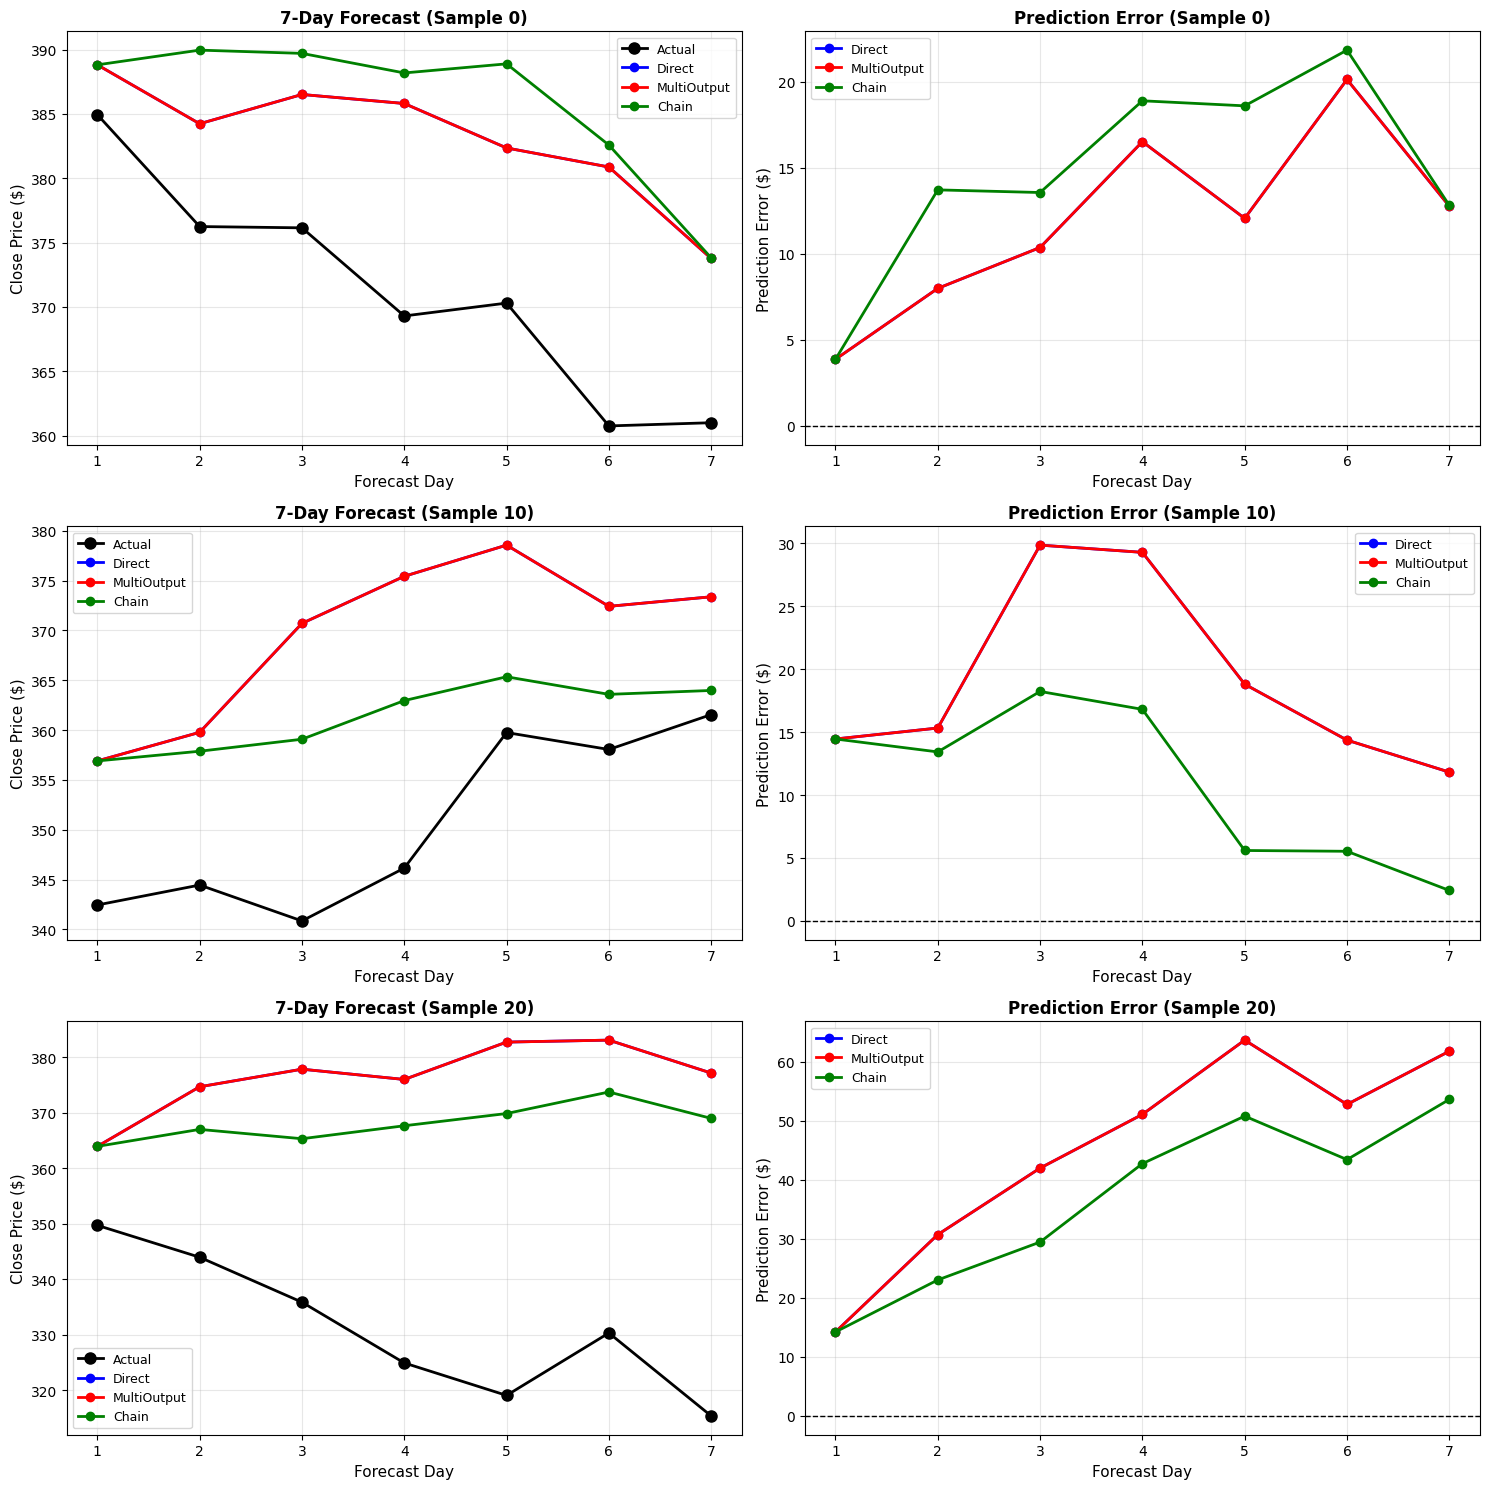

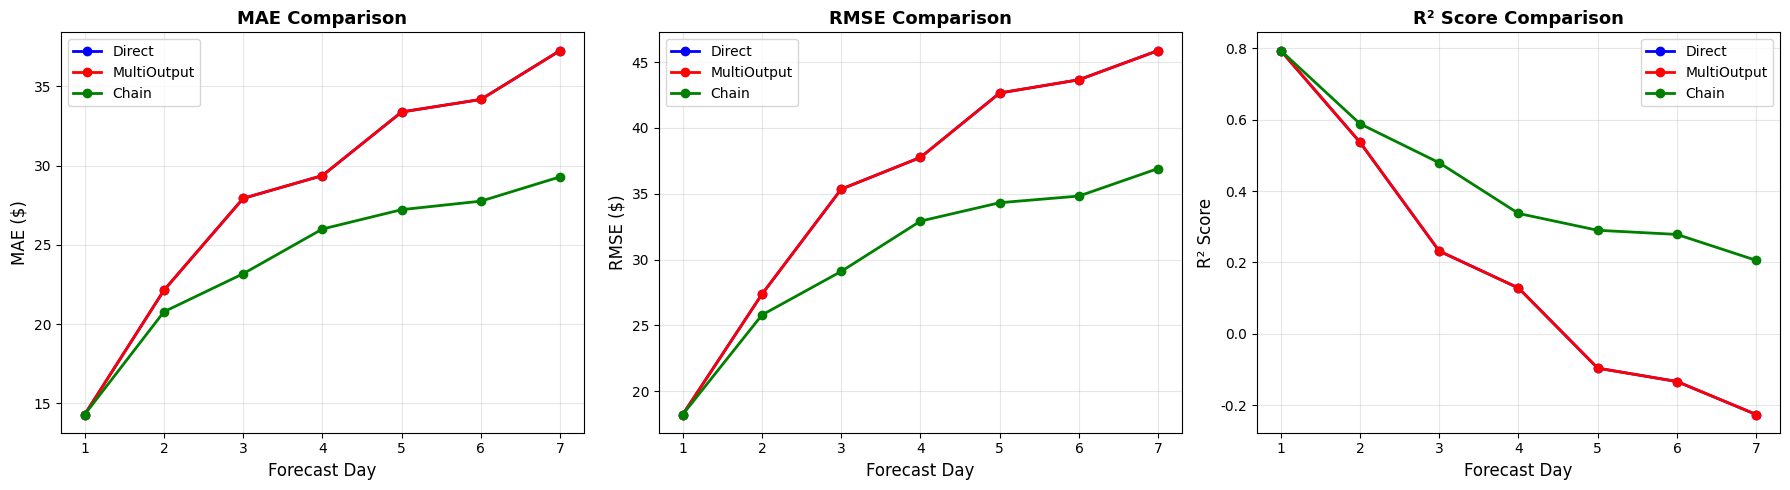

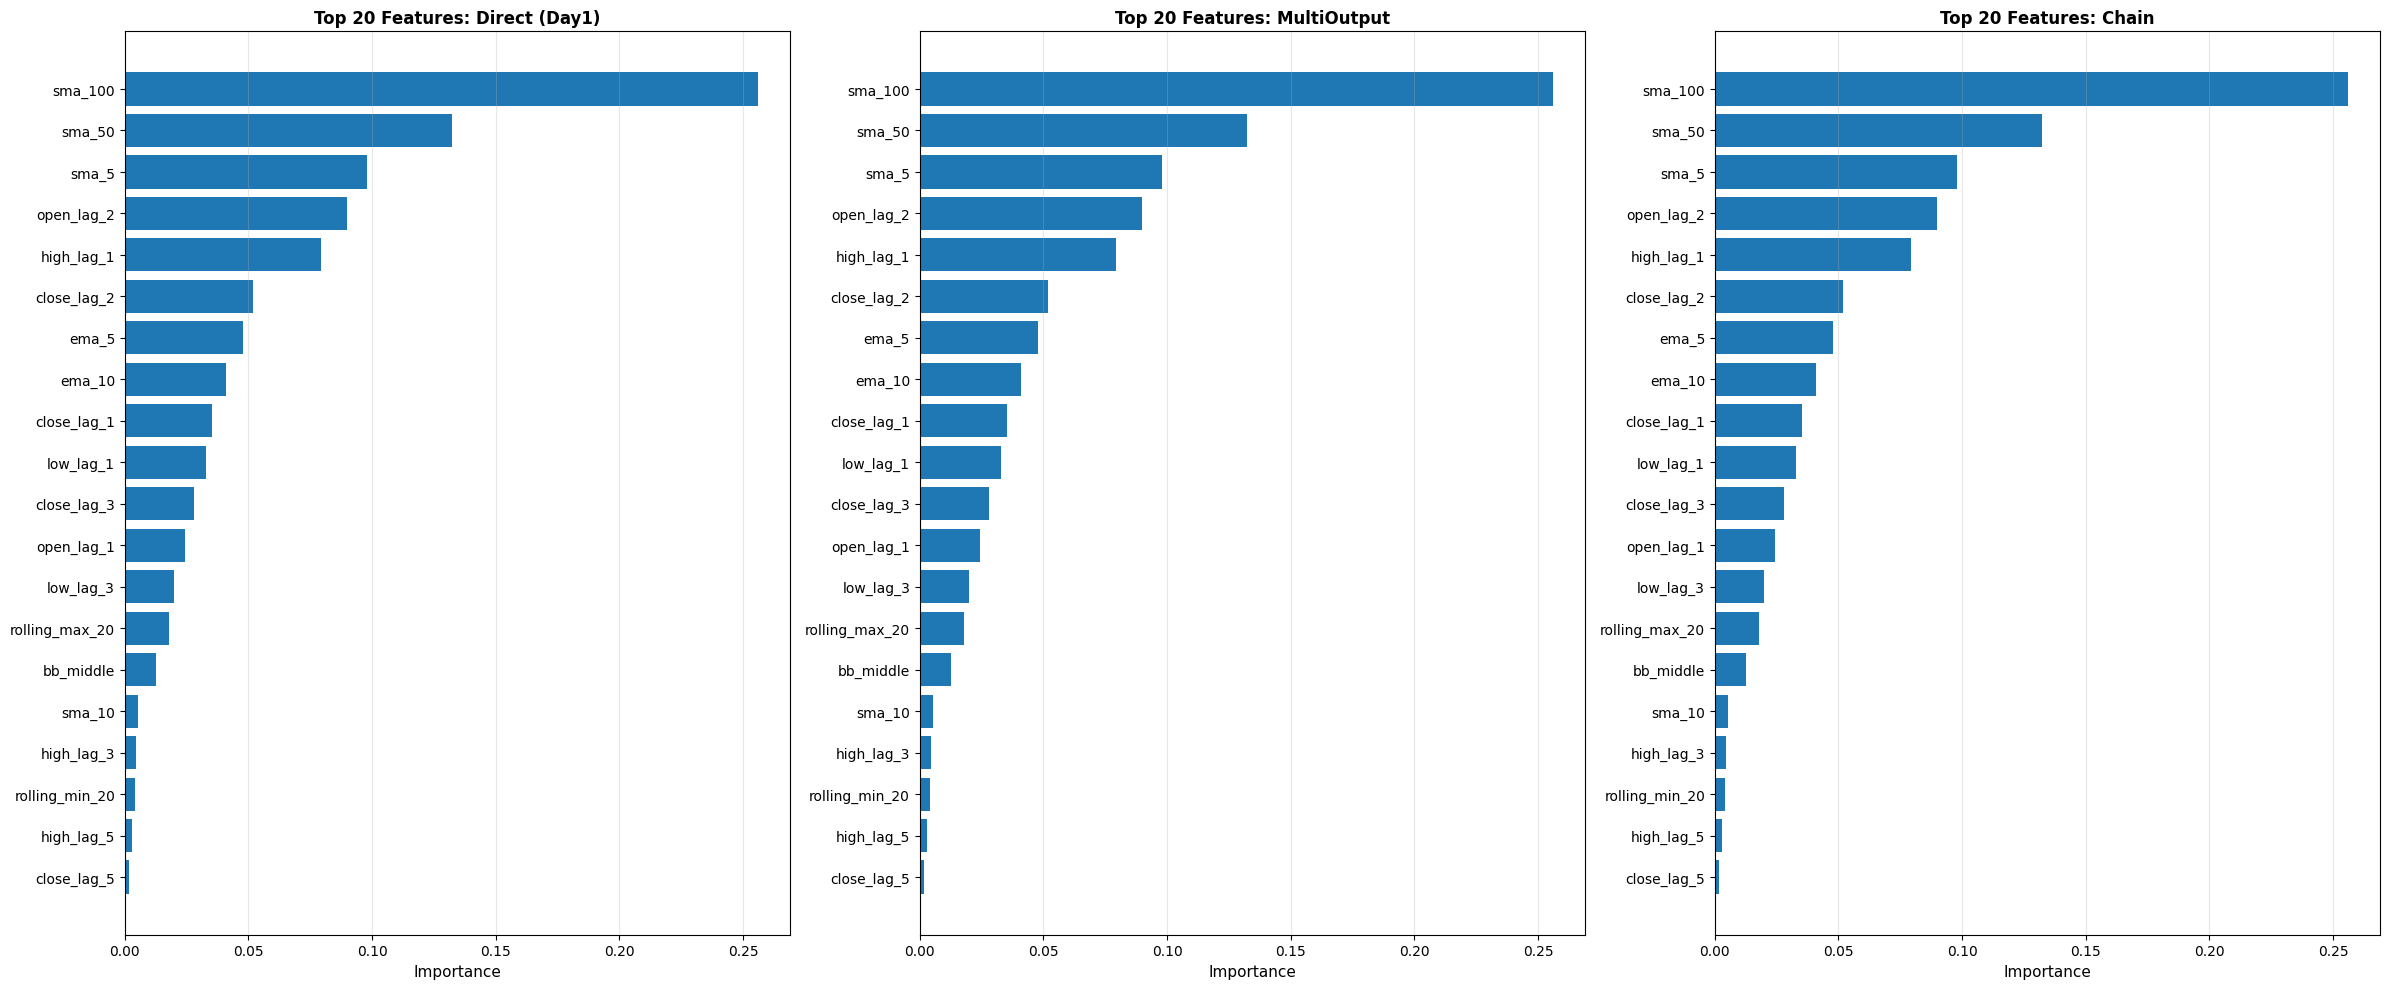

In [ ]:
# ============================================================================
# 메인 실행 예시
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("XGBoost Multi-step Forecasting 구현")
    print("="*80)

    # ========================================================================
    # 1. 데이터 로드 및 준비
    # ========================================================================
    print("\n[1단계] 데이터 로드 및 준비")
    print("-"*80)

    # 예시: 이미 feature engineering이 완료된 데이터 로드
    # df = pd.read_csv('coffee_features_clean.csv')
    df['Date'] = pd.to_datetime(df['Date'])

    # 여기서는 사용자가 이미 준비한 데이터를 사용한다고 가정
    df_features = create_all_features(df, include_target=False, remove_nan=False)

    # ========================================================================
    # 2. Multi-step 타겟 생성
    # ========================================================================
    print("\n[2단계] Multi-step 타겟 생성")
    print("-"*80)

    df_features = create_direct_multistep_targets(df_features, forecast_days=7)
    df_clean = df_features.dropna()
    print(f"✅ 유효 데이터: {len(df_clean)}행")

    # ========================================================================
    # 3. Feature와 Target 분리
    # ========================================================================
    print("\n[3단계] Feature와 Target 분리")
    print("-"*80)

    original_cols = ['Date','Close_Price', 'High_Price', 'Low', 'Open', 'Volume']
    target_cols = [f'target_day{i}' for i in range(1, 8)]
    feature_cols = [col for col in df_clean.columns
                   if col not in original_cols + target_cols]

    X = df_clean[feature_cols]
    print(f"\nFeature 개수: {X.shape[1]}")
    print(f"Target 개수: {len(target_cols)}")
    print(f"\nFeature 목록:")
    for i, col in enumerate(X.columns, 1):
      print(f"  {i}. {col}")

    # Train/Test Split (시계열 순서 유지)
    train_size = int(len(df_clean) * 0.9)
    X_train, X_test = X[:train_size], X[train_size:]

    print(f"✅ Train: {len(X_train)}행")
    print(f"✅ Test: {len(X_test)}행")
    print(f"✅ Features: {len(feature_cols)}개")

    # ========================================================================
    # 4. (선택사항) 하이퍼파라미터 튜닝
    # ========================================================================
    print("\n[4단계] 하이퍼파라미터 튜닝 (선택사항)")
    print("-"*80)
    print("※ 튜닝을 원하시면 아래 주석을 해제하세요")

    # # Day 1 예측용으로 튜닝 (다른 날에도 동일한 파라미터 적용)
    y_train_day1 = df_clean[f'target_day1'].values[:train_size]
    best_params = tune_xgboost_params(X_train, y_train_day1, n_splits=3, n_iter=20)
    use_tuned = True

    #use_tuned = False
    #best_params = None

    # ========================================================================
    # 5. 방법 1: Direct Multi-step XGBoost
    # ========================================================================
    print("\n[5단계] 방법별 모델 학습")
    print("-"*80)

    y_train_dict = {i: df_clean[f'target_day{i}'].values[:train_size]
                    for i in range(1, 8)}
    y_test_dict = {i: df_clean[f'target_day{i}'].values[train_size:]
                   for i in range(1, 8)}

    direct_models, direct_preds, direct_metrics = train_direct_multistep_xgboost(
        X_train, y_train_dict, X_test, y_test_dict,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 6. 방법 2: Multiple Output XGBoost
    # ========================================================================
    y_train_array = df_clean[target_cols].values[:train_size]
    y_test_array = df_clean[target_cols].values[train_size:]

    multi_model, multi_preds, multi_metrics = train_multiple_output_xgboost(
        X_train, y_train_array, X_test, y_test_array,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 7. 방법 3: Native Multi-output XGBoost (Chain)
    # ========================================================================
    chain_models, chain_preds, chain_metrics = train_native_multioutput_xgboost(
        X_train, y_train_array, X_test, y_test_array,
        use_tuned_params=use_tuned, best_params=best_params
    )

    # ========================================================================
    # 8. 성능 비교
    # ========================================================================
    print("\n[8단계] 성능 비교 및 시각화")
    print("-"*80)

    method_metrics_dict = {
        'Direct': direct_metrics,
        'MultiOutput': multi_metrics,
        'Chain': chain_metrics
    }

    comparison_df = compare_methods(method_metrics_dict)

    # ========================================================================
    # 9. 시각화
    # ========================================================================
    direct_preds_array = np.column_stack([direct_preds[i] for i in range(1, 8)])

    predictions_dict = {
        'Direct': direct_preds_array,
        'MultiOutput': multi_preds,
        'Chain': chain_preds
    }

    # 예측값 비교
    plot_predictions(
        y_test_array,
        predictions_dict,
        sample_indices=[0, 10, 20],
        save_path='xgb_multistep_predictions.png'
    )

    # 성능 비교
    plot_method_comparison(
        comparison_df,
        save_path='xgb_multistep_performance.png'
    )

    # Feature Importance
    models_dict_for_importance = {
        'Direct (Day1)': direct_models, # Pass the dictionary for Direct
        'MultiOutput': multi_model,
        'Chain': chain_models
    }

    analyze_feature_importance(
        models_dict_for_importance,
        feature_names=feature_cols,
        top_n=20,
        save_path='xgb_multistep_feature_importance.png'
    )

    print("\n" + "="*80)
    print("✅ 완료!")
    print("="*80)
    print("\n💡 사용 팁:")
    print("1. Direct 방법: 각 예측일마다 독립적, 가장 정확하지만 7개 모델 필요")
    print("2. MultiOutput 방법: 하나의 모델로 효율적, 예측일 간 관계 학습 부족")
    print("3. Chain 방법: 이전 예측을 활용, 중간 성능이지만 에러 누적 가능")
    print("\n🎯 권장: 데이터 크기와 요구사항에 따라 Direct 또는 Chain 방법 사용")